In [18]:
!pip install praw nltk textblob sumy


import logging

# Set logging level to suppress PRAW warning messages
logging.getLogger("praw").setLevel(logging.WARNING)
logging.getLogger("praw").setLevel(logging.ERROR)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 14.1 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21691 sha256=d260488afedf4f9dce87ceabfc44d43e619138b2e2c0d3d4658a9a01f3219909
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=848c1aa9caa116a6f13a584afa5db7cebc8d47f42d34652b125fa843e7af9390
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:

import re
import praw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
from collections import Counter
import ast

from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

import gensim
from gensim import corpora
from pprint import pprint

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter

In [2]:
# from transformers import pipeline
# # Load the sentiment analysis pipeline
# classifier = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",return_all_scores=False)
# summarizer = pipeline("summarization")

In [3]:
# Set logging level to suppress PRAW warning messages
logging.getLogger("praw").setLevel(logging.WARNING)
logging.getLogger("praw").setLevel(logging.ERROR)
# Reddit API credentials
reddit_client_id = 'bLfHRgL3R8y69_QUj7xMrA'
reddit_client_secret = 'HO0fvx3tIbnujuyCqIPmjXT9lopiCg'
reddit_user_agent = 'CommunicationTop2560'


# Initialize Reddit API
reddit = praw.Reddit(
    client_id=reddit_client_id,
    client_secret=reddit_client_secret,
    user_agent=reddit_user_agent
)

# Assuming you have initialized the Reddit instance
# reddit = praw.Reddit(client_id='your_client_id', client_secret='your_client_secret', user_agent='your_user_agent')

# Specify the subreddit name
subreddit_name = 'movies'

# Create a list to store posts
posts_list = []

# Get posts from the subreddit with titles containing 'KGF'
for submission in reddit.subreddit(subreddit_name).search('Avengers', sort='new', time_filter='all'):
    posts_list.append({
        'Post_id': submission.id,
        'title': submission.title,
        #'created_utc': submission.created_utc,
        'Post_author': str(submission.author) if submission.author else '[Unknown_Author]',
        'score': submission.score,
        'num_comments': submission.num_comments,
        'url': submission.url,
        'permalink': submission.permalink
    })

# Convert the list of posts into a DataFrame
Avengers_posts_df = pd.DataFrame(posts_list)

# Display the resulting DataFrame
(Avengers_posts_df)


,Post_id,title,Post_author,score,num_comments,url,permalink
0,1995eme,Family script reading for fun,LeafsPain,0,9,https://www.reddit.com/r/movies/comments/1995e...,/r/movies/comments/1995eme/family_script_readi...
1,19812av,Which movies often get misinterpreted as being...,SoulsbourneDiesTwice,0,16,https://www.reddit.com/r/movies/comments/19812...,/r/movies/comments/19812av/which_movies_often_...
2,197ky2v,What was the most hyped movie of all time?,foxxgod,0,95,https://www.reddit.com/r/movies/comments/197ky...,/r/movies/comments/197ky2v/what_was_the_most_h...
3,196vmc4,The entire movie Unforgiven hinges on Quick Mi...,time2payfiddlerwhore,136,42,https://www.reddit.com/r/movies/comments/196vm...,/r/movies/comments/196vmc4/the_entire_movie_un...
4,196umdc,Favorite Obscure/Cult Movies everyone should w...,Terpcheeserosin,43,374,https://www.reddit.com/r/movies/comments/196um...,/r/movies/comments/196umdc/favorite_obscurecul...
...,...,...,...,...,...,...,...
95,15k6wzg,"Forgive me if this type of post isn't allowed,...",IHaveTrustIssues78,0,17,https://www.reddit.com/r/movies/comments/15k6w...,/r/movies/comments/15k6wzg/forgive_me_if_this_...
96,15imd90,‘Teenage Mutant Ninja Turtles: Mutant Mayhem’ ...,lowell2017,12,4,https://www.hollywoodreporter.com/movies/movie...,/r/movies/comments/15imd90/teenage_mutant_ninj...
97,15hz2k3,Famous Character Battle Royale,K0nathedog,1,15,https://www.reddit.com/r/movies/comments/15hz2...,/r/movies/comments/15hz2k3/famous_character_ba...
98,15ep1ah,"What is the most epic ""movie moment"" you have ...",weprin0912,2338,2834,https://www.reddit.com/r/movies/comments/15ep1...,/r/movies/comments/15ep1ah/what_is_the_most_ep...


In [4]:
Avengers_posts_df.columns

Index(['Post_id', 'title', 'Post_author', 'score', 'num_comments', 'url',
       'permalink'],
      dtype='object')

In [5]:
# def Comment_Sentiment(review):
#     result = ''
#     output = ''

#     try:
#         if len(review) > 512:
#             summary = summarizer(review, max_length=512, min_length=50, length_penalty=2.0, num_beams=4, no_repeat_ngram_size=2, early_stopping=True)
#             result = classifier(summary[0]['summary_text'])
#         else:
#             result = classifier(review)

#         if result[0]['label'].upper() == 'POSITIVE':
#             if result[0]['score'] >= 0.99:
#                 output = 'EXTREMELY POSITIVE'
#             elif 0.40 <= result[0]['score'] < 0.99:
#                 output = 'POSITIVE'
#             else:
#                 output = 'NEUTRAL'
#         elif result[0]['label'].upper() == 'NEGATIVE':
#             if result[0]['score'] >= 0.99:
#                 output = 'EXTREMELY NEGATIVE'
#             elif 0.40 <= result[0]['score'] < 0.99:
#                 output = 'NEGATIVE'
#             else:
#                 output = 'NEUTRAL'
#         else:
#             output = 'NEUTRAL'

#     except Exception as e:
#         print(f"Error in Comment_Sentiment: {str(e)}")
#         output = 'NEUTRAL'

#     return output


In [10]:
# Reddit API credentials
reddit_client_id = 'bLfHRgL3R8y69_QUj7xMrA'
reddit_client_secret = 'HO0fvx3tIbnujuyCqIPmjXT9lopiCg'
reddit_user_agent = 'CommunicationTop2560'

# Initialize Reddit API
reddit = praw.Reddit(
    client_id=reddit_client_id,
    client_secret=reddit_client_secret,
    user_agent=reddit_user_agent
)

# Function to perform sentiment analysis using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Function to extract comments with sentiment analysis
def get_comments_tree(comment, post_id, title, post_upvotes, post_author, post_no_comments, post_url, parent_comment_id=None):
    comments_list = []

    try:
        if isinstance(comment, praw.models.MoreComments):
            # Handle MoreComments object (optional)
            return comments_list

        sentiment = analyze_sentiment(comment.body)  # Perform sentiment analysis

        comment_details = {
            'Post_ID': post_id,
            'Title': title,
            'Post_Score': post_upvotes,
            'Post_Author': post_author if post_author else '[Unknown_Author]',
            'No._of_Comments': post_no_comments,
            'Post_URL': post_url,
            'Comment_ID': comment.id,
            'Parent_Comment_ID': parent_comment_id,
            'Comment_Body': comment.body,
            'Comment_Author': str(comment.author) if comment.author else '[Unknown_Author]',
            'Comment_Upvotes': comment.score,
            'Comment_Sentiment': sentiment
        }
        comments_list.append(comment_details)

        for reply in comment.replies:
            comments_list.extend(get_comments_tree(reply, post_id, title, post_upvotes, post_author, post_no_comments, post_url, parent_comment_id=comment.id))

    except Exception as e:
        print(f"Error processing comment: {str(e)}")

    return comments_list

# Create a list to store all comments details for all posts
all_comments_list = []

# Loop through each post in Avengers_posts_df
for index, row in Avengers_posts_df.iterrows():
    post_id = row['Post_id']
    post_upvotes = row['score']
    post_author = row['Post_author']
    post_no_comments = row['num_comments']
    post_url = row['url']
    post_title = row['title']

    # Fetch details for the specified post
    post = reddit.submission(id=post_id)

    # Create a list to store comments details for the current post
    comments_list = []

    # Extract details for each comment in the post (top-level comments)
    for top_level_comment in post.comments:
        comments_list.extend(get_comments_tree(top_level_comment, post_id, post_title, post_upvotes, post_author, post_no_comments, post_url))

    # Append comments_list to all_comments_list
    all_comments_list.extend(comments_list)

# Create a DataFrame for all comments
all_comments_df = pd.DataFrame(all_comments_list)

# Display the resulting DataFrame for all posts
print("\nAll Comments Details:")
all_comments_df


All Comments Details:
       Post_ID                          Title  Post_Score       Post_Author  \
0      1995eme  Family script reading for fun           0         LeafsPain   
1      1995eme  Family script reading for fun           0         LeafsPain   
2      1995eme  Family script reading for fun           0         LeafsPain   
3      1995eme  Family script reading for fun           0         LeafsPain   
4      1995eme  Family script reading for fun           0         LeafsPain   
...        ...                            ...         ...               ...   
12067  15c51qg          Where's J. J. Abrams?        1189  OkInvestment2244   
12068  15c51qg          Where's J. J. Abrams?        1189  OkInvestment2244   
12069  15c51qg          Where's J. J. Abrams?        1189  OkInvestment2244   
12070  15c51qg          Where's J. J. Abrams?        1189  OkInvestment2244   
12071  15c51qg          Where's J. J. Abrams?        1189  OkInvestment2244   

       No._of_Comments      

In [12]:
all_comments_df.Comment_Sentiment.value_counts()

Positive    6374
Neutral     3309
Negative    2389
Name: Comment_Sentiment, dtype: int64

In [ ]:
# all_comments_df.to_csv("Reddit_Avengers_data.csv")

In [ ]:
# def Comment_Sentiment (review):
#      result=''
#      output =''
#      if len(review) > 512:
#           summary = summarizer(review, max_length=512, min_length=50, length_penalty=2.0, num_beams=4, no_repeat_ngram_size=2, early_stopping=True)
#           result = classifier(summary[0]['summary_text'])
#      else:
#           result = classifier(review)
#      if result[0]['label'].upper() == 'POSITIVE':
#         if result[0]['score'] >= 0.99:
#             output = 'EXTREMELY POSITIVE'
#         elif 0.40 <= result[0]['score'] < 0.99:
#             output = 'POSITIVE'
#         else:
#             output = 'NEUTRAL'
#      elif result[0]['label'].upper() == 'NEGATIVE':
#          if result[0]['score'] >= 0.99:
#             output = 'EXTREMELY NEGATIVE'
#          elif 0.40 <= result[0]['score'] < 0.99:
#             output = 'NEGATIVE'
#          else:
#             output = 'NEUTRAL'
#      else:
#            output = 'NEUTRAL'

In [15]:
all_comments_df.columns

Index(['Post_ID', 'Title', 'Post_Score', 'Post_Author', 'No._of_Comments',
       'Post_URL', 'Comment_ID', 'Parent_Comment_ID', 'Comment_Body',
       'Comment_Author', 'Comment_Upvotes', 'Comment_Sentiment'],
      dtype='object')

In [16]:
# Combine all comments into a single text
all_comments_text = ' '.join(all_comments_df['Comment_Body'])

In [19]:
from nltk.tokenize import word_tokenize
tokens = word_tokenize(all_comments_text.lower())

In [20]:
from nltk.corpus import stopwords
import string
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]

In [21]:
from collections import Counter
word_freq = Counter(filtered_tokens)

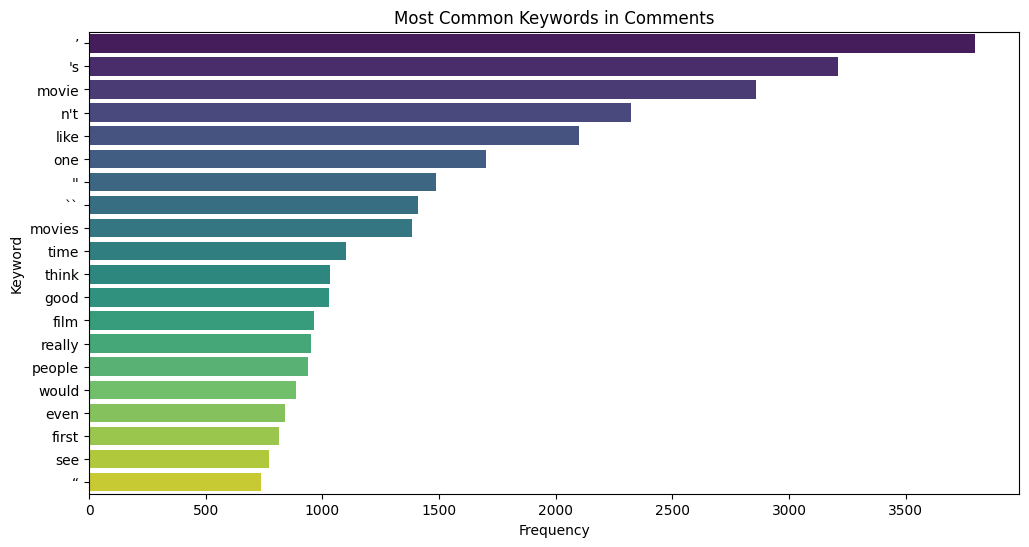

In [24]:
# Get the most common keywords
most_common_keywords = word_freq.most_common(20)

# Plot the most common keywords
plt.figure(figsize=(12, 6))
sns.barplot(x=[x[1] for x in most_common_keywords], y=[x[0] for x in most_common_keywords], palette="viridis")
plt.title('Most Common Keywords in Comments')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

In [28]:
top_comment_authors = all_comments_df['Comment_Author'].value_counts().head(10)

# Top comment authors by total upvotes
top_comment_authors_by_upvotes = all_comments_df.groupby('Comment_Author')['Comment_Upvotes'].sum().sort_values(ascending=False).head(10)
top_comment_authors_by_upvotes

Comment_Author
[Unknown_Author]        19534
mikeyfreshh              9702
slylock215               5340
riegspsych325            4945
Perfect-Evidence5503     4852
jaeldi                   3830
Heiminator               3765
KurRatcrusher            3110
TheBlackSwarm            2892
AtlanteanX               2856
Name: Comment_Upvotes, dtype: int64

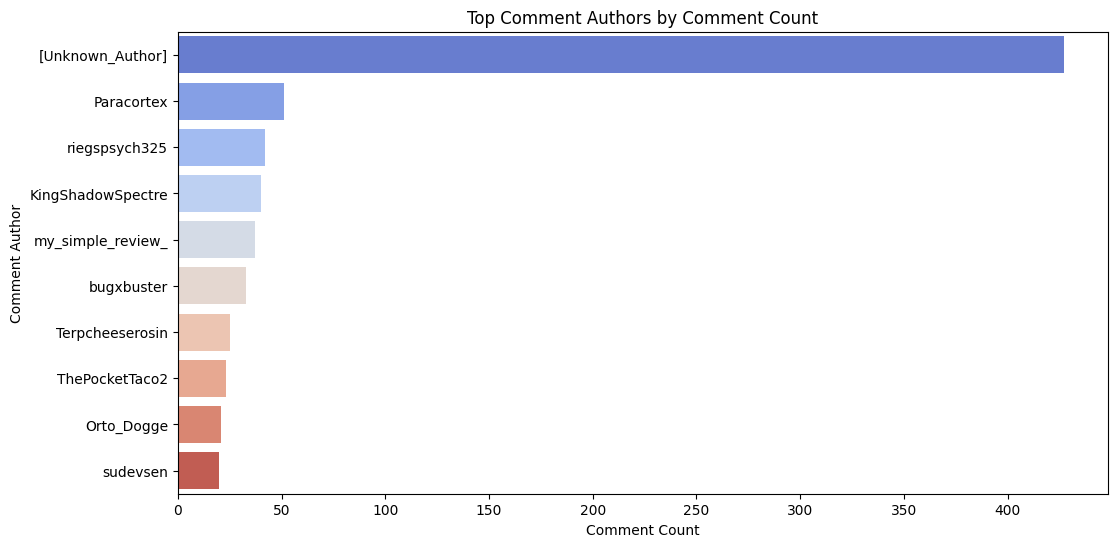

In [29]:
# Plot the top comment authors by comment count
plt.figure(figsize=(12, 6))
sns.barplot(x=top_comment_authors.values, y=top_comment_authors.index, palette="coolwarm")
plt.title('Top Comment Authors by Comment Count')
plt.xlabel('Comment Count')
plt.ylabel('Comment Author')
plt.show()

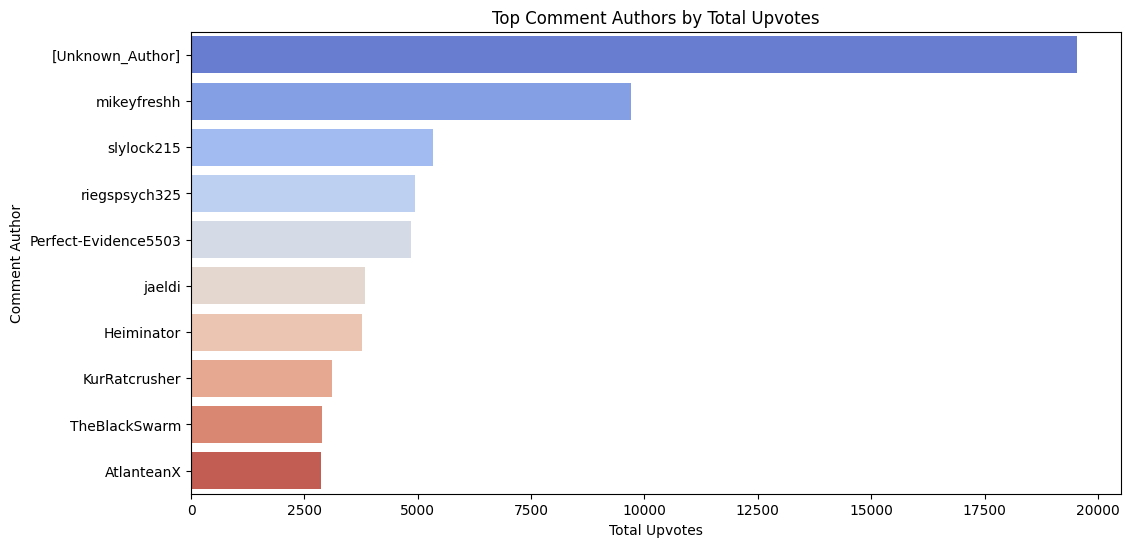

In [30]:
# Plot the top comment authors by total upvotes
plt.figure(figsize=(12, 6))
sns.barplot(x=top_comment_authors_by_upvotes.values, y=top_comment_authors_by_upvotes.index, palette="coolwarm")
plt.title('Top Comment Authors by Total Upvotes')
plt.xlabel('Total Upvotes')
plt.ylabel('Comment Author')
plt.show()

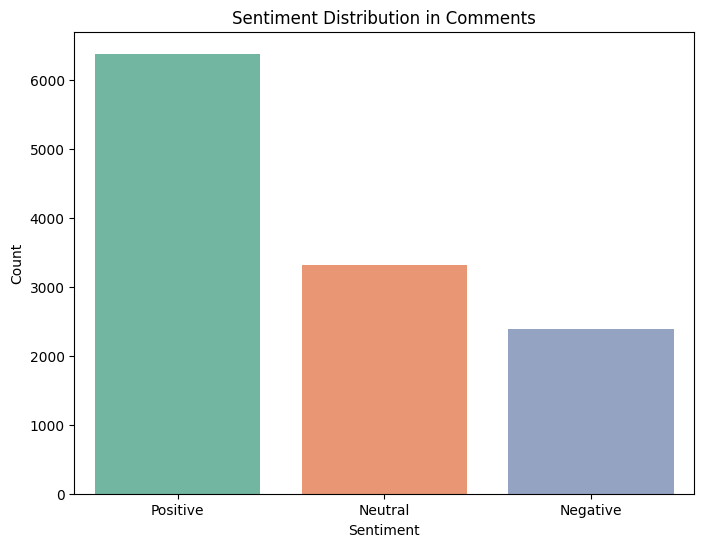

In [31]:
# Sentiment distribution
sentiment_counts = all_comments_df['Comment_Sentiment'].value_counts()

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Set2")
plt.title('Sentiment Distribution in Comments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=10, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(all_comments_df['Comment_Body'])

# Perform K-means clustering
num_clusters = 5  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(tfidf_matrix)

# Assign cluster labels to comments
all_comments_df['Cluster_Label'] = kmeans.labels_


In [33]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit LDA model to each cluster
lda_models = []
for cluster in range(num_clusters):
    cluster_comments = all_comments_df[all_comments_df['Cluster_Label'] == cluster]['Comment_Body']
    tfidf_matrix_cluster = tfidf_vectorizer.transform(cluster_comments)

    lda = LatentDirichletAllocation(n_components=5, random_state=42)  # You can adjust the number of topics
    lda.fit(tfidf_matrix_cluster)
    lda_models.append(lda)

# Extract top topics and their associated words for each cluster
topics_per_cluster = []
for i, lda in enumerate(lda_models):
    top_topics = lda.transform(tfidf_matrix_cluster)
    top_topic_idx = top_topics.argmax(axis=1)
    top_topic_words = [lda.components_[j].argsort()[-5:][::-1] for j in top_topic_idx]

    topics_per_cluster.append(top_topic_words)


In [37]:
# from sklearn.decomposition import LatentDirichletAllocation

# # Limit the analysis to 5 clusters
# num_clusters = 5

# # Fit LDA model to each cluster
# lda_models = []
# for cluster in range(num_clusters):
#     cluster_comments = all_comments_df[all_comments_df['Cluster_Label'] == cluster]['Comment_Body']
#     tfidf_matrix_cluster = tfidf_vectorizer.transform(cluster_comments)

#     lda = LatentDirichletAllocation(n_components=5, random_state=42)  # You can adjust the number of topics
#     lda.fit(tfidf_matrix_cluster)
#     lda_models.append(lda)

# # Extract top topics and their associated words for each cluster
# topics_per_cluster = []
# for i, lda in enumerate(lda_models):
#     top_topics = lda.transform(tfidf_matrix_cluster)
#     top_topic_idx = top_topics.argmax(axis=1)
#     top_topic_words = [lda.components_[j].argsort()[-5:][::-1] for j in top_topic_idx]
#     #
#     topics_per_cluster.append(top_topic_words)

# # Print the results in a readable sentence format
# for cluster, topics in enumerate(topics_per_cluster):
#     print(f"\nCluster {cluster + 1} Topics:")
#     for topic_idx, topic_words in enumerate(topics):
#         top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic_words]
#         print(f"Topic {topic_idx + 1}: {' | '.join(top_words)}")

#     # Print the dominant topic for each comment within the cluster
#     cluster_comments = all_comments_df[all_comments_df['Cluster_Label'] == cluster]
#     lda = lda_models[cluster]
#     topic_assignments = lda.transform(tfidf_vectorizer.transform(cluster_comments['Comment_Body']))
#     dominant_topics = topic_assignments.argmax(axis=1)

#     print(f"\nDominant Topics in Cluster {cluster + 1} Comments:")
#     for idx, comment in enumerate(cluster_comments['Comment_Body']):
#         print(f"Comment {idx + 1}: '{comment[:100]}' is associated with Topic {dominant_topics[idx] + 1}")


Streaming output truncated to the last 5000 lines.
Topic 424: deleted | zombie | filled | films | filmmaking
Topic 425: deleted | zombie | filled | films | filmmaking
Topic 426: deleted | zombie | filled | films | filmmaking
Topic 427: deleted | zombie | filled | films | filmmaking
Topic 428: deleted | zombie | filled | films | filmmaking
Topic 429: deleted | zombie | filled | films | filmmaking
Topic 430: deleted | zombie | filled | films | filmmaking
Topic 431: deleted | zombie | filled | films | filmmaking
Topic 432: deleted | zombie | filled | films | filmmaking
Topic 433: deleted | zombie | filled | films | filmmaking
Topic 434: deleted | zombie | filled | films | filmmaking
Topic 435: deleted | zombie | filled | films | filmmaking
Topic 436: deleted | zombie | filled | films | filmmaking
Topic 437: deleted | zombie | filled | films | filmmaking
Topic 438: deleted | zombie | filled | films | filmmaking
Topic 439: deleted | zombie | filled | films | filmmaking
Topic 440: deleted | 

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

# Limit the analysis to 5 clusters
num_clusters = 5

# Fit LDA model to each cluster
lda_models = []
for cluster in range(num_clusters):
    cluster_comments = all_comments_df[all_comments_df['Cluster_Label'] == cluster]['Comment_Body']
    tfidf_matrix_cluster = tfidf_vectorizer.transform(cluster_comments)

    lda = LatentDirichletAllocation(n_components=5, random_state=42)  # You can adjust the number of topics
    lda.fit(tfidf_matrix_cluster)
    lda_models.append(lda)

# Print the results in a readable sentence format
for cluster, lda in enumerate(lda_models):
    print(f"\nCluster {cluster + 1} Topics:")

    # Print the dominant topic for each comment within the cluster
    cluster_comments = all_comments_df[all_comments_df['Cluster_Label'] == cluster]
    topic_assignments = lda.transform(tfidf_vectorizer.transform(cluster_comments['Comment_Body']))
    dominant_topics = topic_assignments.argmax(axis=1)

    print(f"Dominant Topics in Cluster {cluster + 1} Comments:")
    for idx, comment in enumerate(cluster_comments['Comment_Body']):
        print(f"Comment {idx + 1}: '{comment[:100]}' is associated with Topic {dominant_topics[idx] + 1}")


Streaming output truncated to the last 5000 lines.
Comment 499: 'Oh really, the people that chose to subscribe to a subreddit exclusively about the series like it? W' is associated with Topic 5
Comment 500: 'now while I’ve enjoyed one or two abrams projects, I can’t deny that david lynch’s approach of the t' is associated with Topic 3
Comment 501: 'That's the thing though, if you have pride in your work, you leave the project, you take your name o' is associated with Topic 2
Comment 502: '>The guy was dealt a really bad hand.

He would've seen the script, the turd that was Episode 8, and' is associated with Topic 1
Comment 503: 'Now I’m imagining a lawyer commercial for cancer caused by lens flares. If you’ve ever worked on a J' is associated with Topic 2
Comment 504: 'I've no idea why "the prequels told a cohesive story" has become such a common phrase over the past ' is associated with Topic 2
Comment 505: 'I wouldn't say I "liked" The Last Jedi, but if I'm forced to watch a sequel m

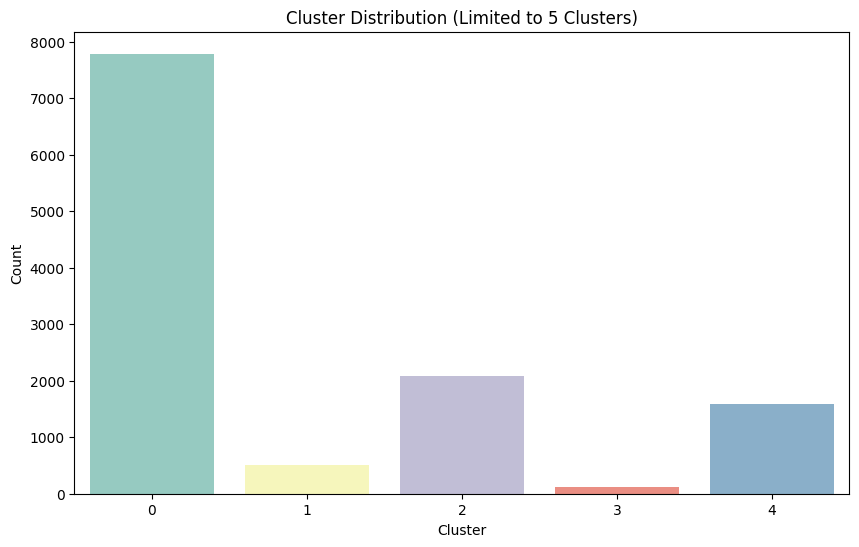

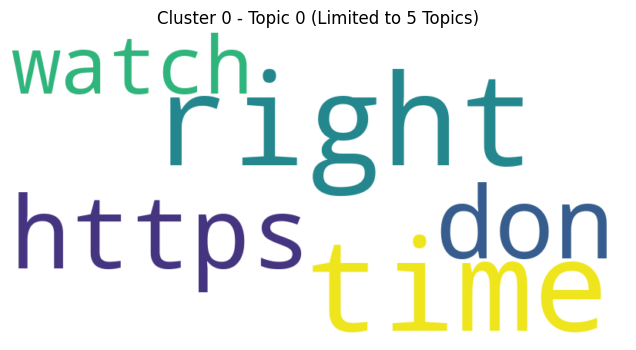

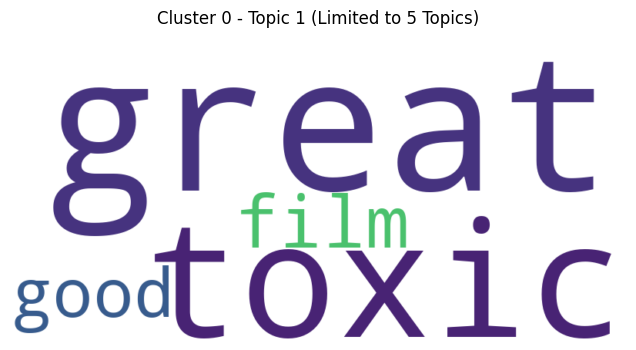

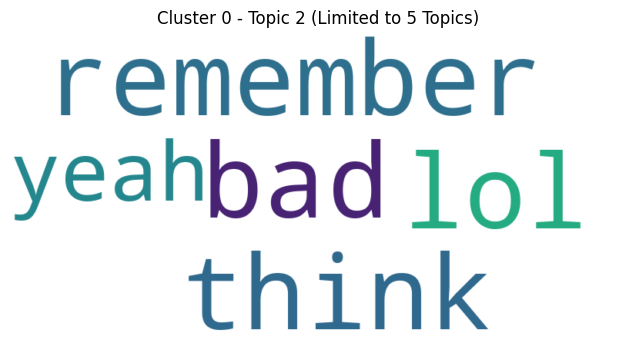

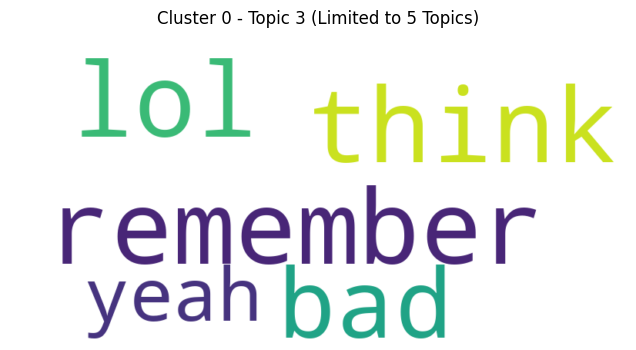

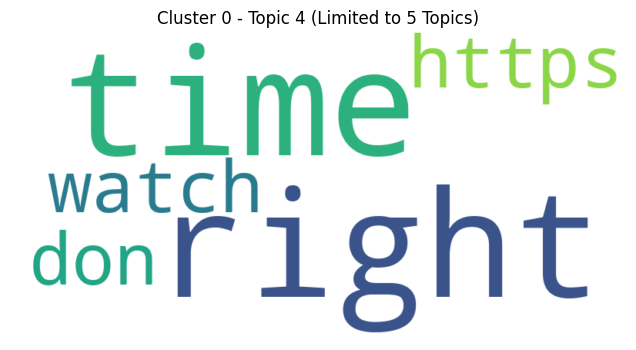

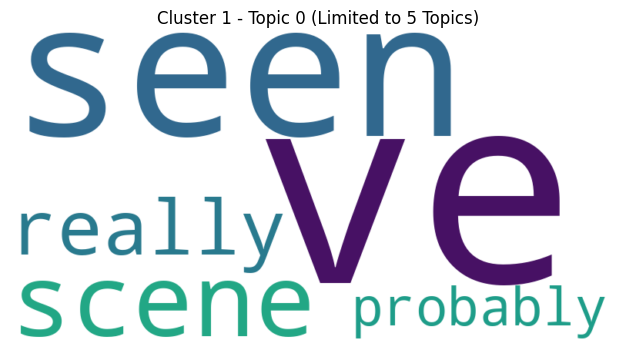

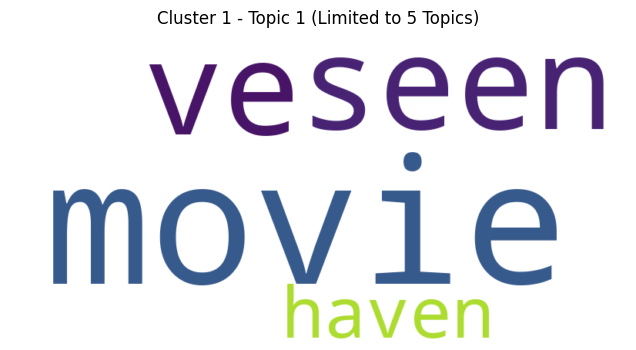

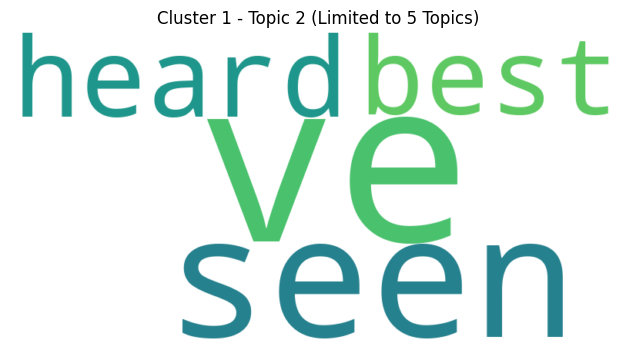

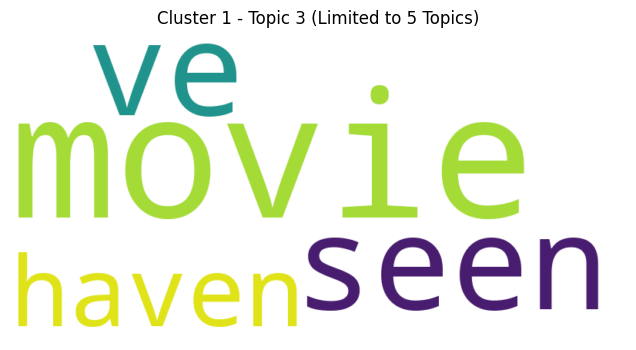

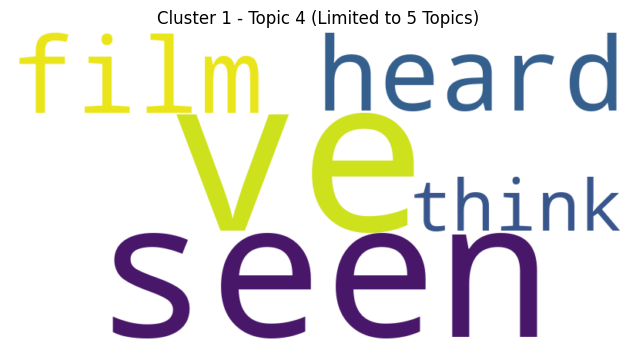

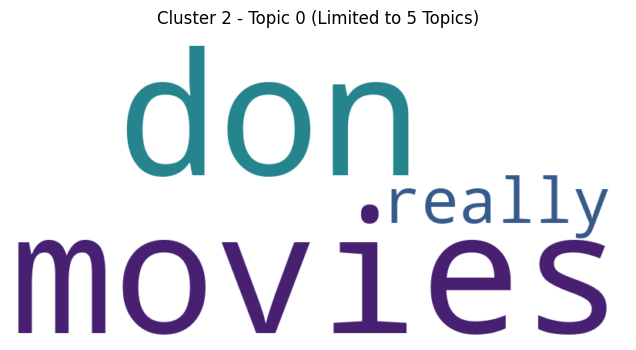

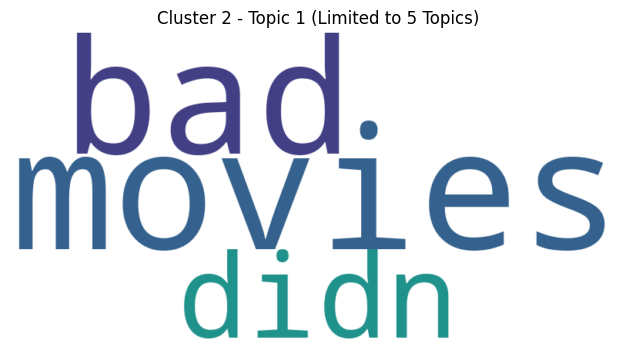

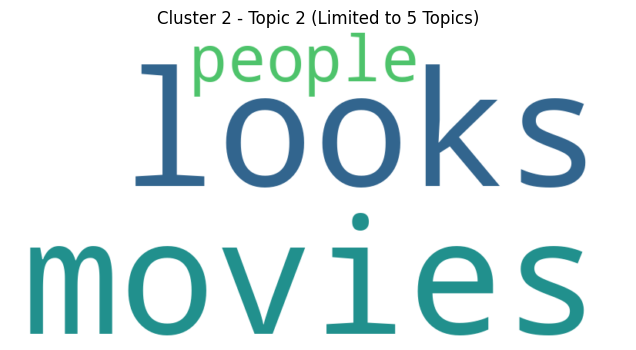

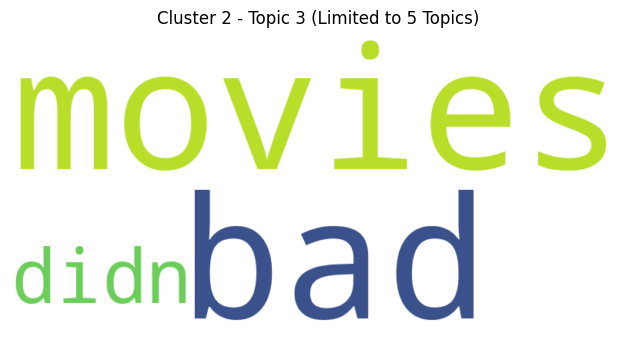

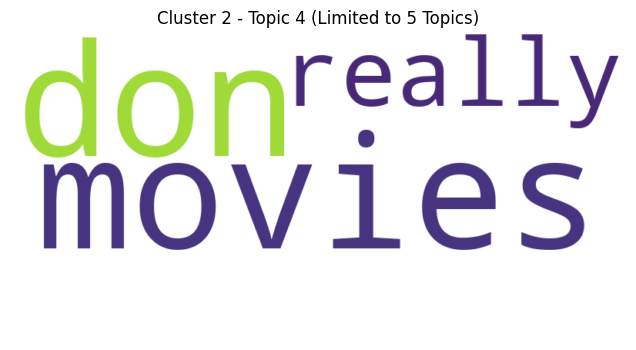

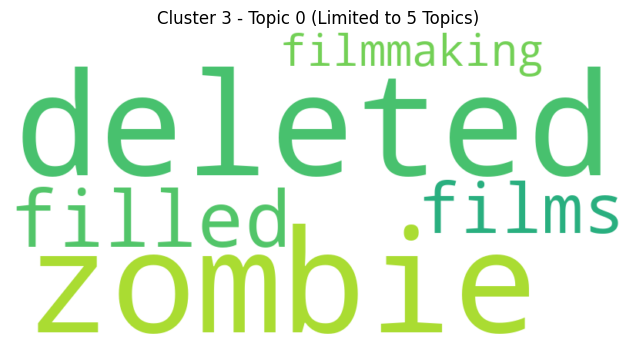

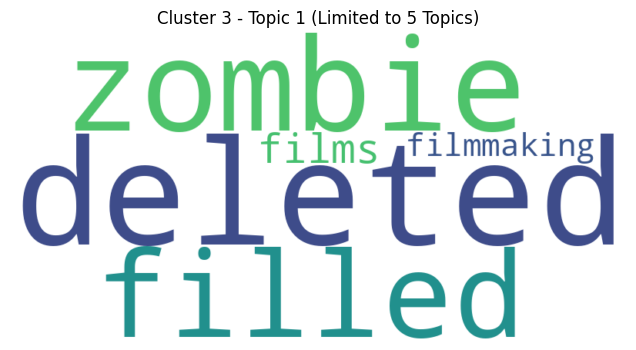

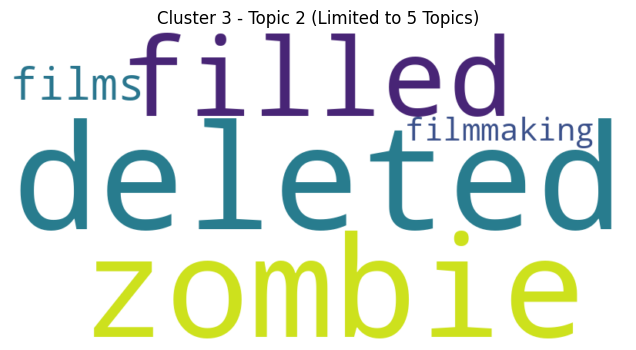

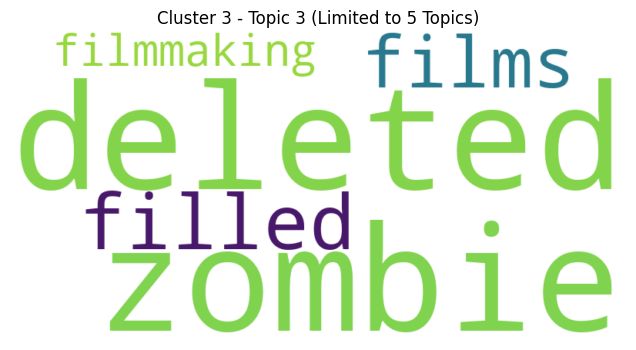

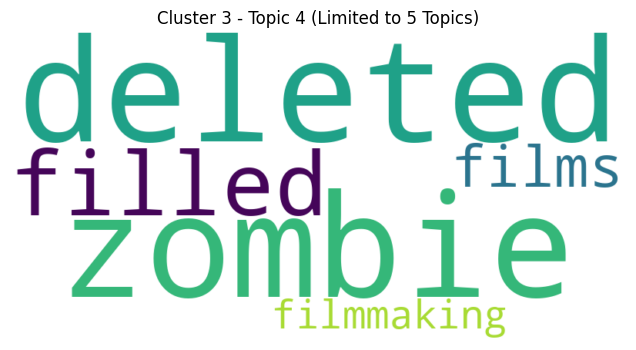

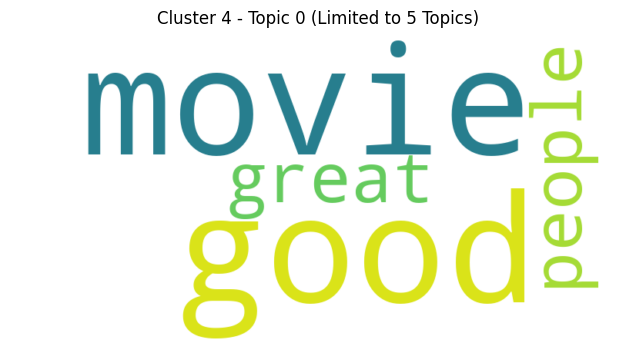

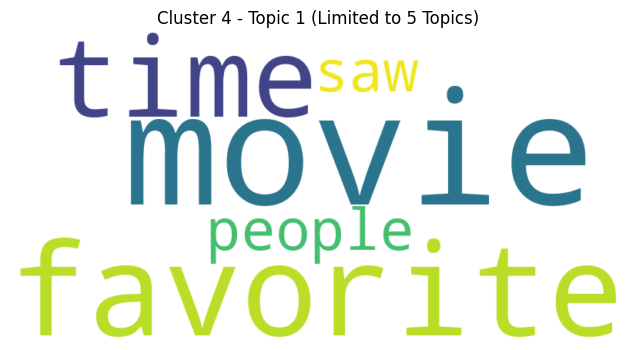

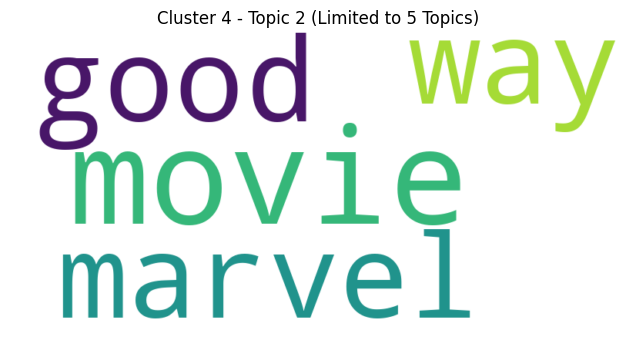

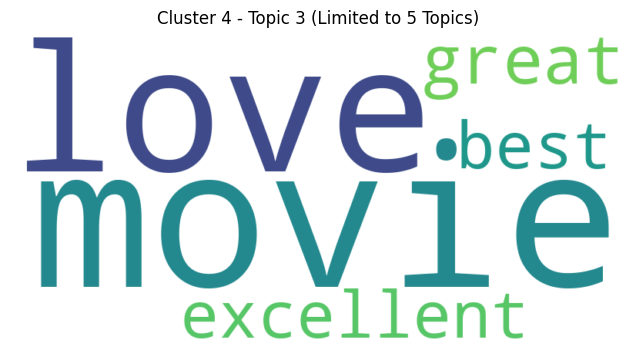

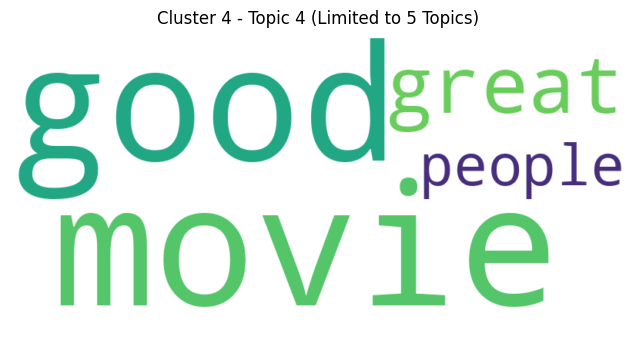

In [35]:
# Limit the analysis to 5 clusters and 5 topics
num_clusters = 5
num_topics = 5

# Visualize cluster distribution for the limited clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster_Label', data=all_comments_df, palette="Set3")
plt.title('Cluster Distribution (Limited to 5 Clusters)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Visualize top words in each topic using word clouds for limited topics and clusters
for cluster, topics in enumerate(topics_per_cluster[:num_clusters]):
    for topic_idx, topic_words in enumerate(topics[:num_topics]):
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic_words]))
        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Cluster {cluster} - Topic {topic_idx} (Limited to 5 Topics)')
        plt.axis('off')
        plt.show()